In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import pandas as pd

In [3]:
from cvxopt import matrix, solvers

In [4]:
from tqdm import tqdm

In [5]:
def is_valid_state(s):
    return (s>=0) and (s<100)

In [6]:
def is_valid_action(a):
    return (a>=0) and (a<4)

In [7]:
def get_row(s):
    return s%10

In [8]:
def get_column(s):
    return s//10

In [9]:
def is_internal_state(s):
    r=is_valid_state(s-1) and is_valid_state(s+1) and is_valid_state(s-10) and is_valid_state(s+10)
    return r and ((get_row(s-10)==get_row(s)) and (get_row(s+10)==get_row(s)) and (get_column(s-1)==get_column(s)) and (get_column(s+1)==get_column(s)))

In [10]:
def state_after_action(s, a):
    if(not(is_valid_state(s))): raise NameError("Invalid state")
    if(not(is_valid_action(a))): raise NameError("Invalid action")
    s1=s
    if(a==0):
        if(is_valid_state(s-1) and (get_column(s-1)==get_column(s))): s1=s-1
    elif(a==1):
        if(is_valid_state(s+10) and (get_row(s+10)==get_row(s))): s1=s+10
    elif(a==2):
        if(is_valid_state(s+1) and (get_column(s+1)==get_column(s))): s1=s+1
    elif(a==3):
        if(is_valid_state(s-10) and (get_row(s-10)==get_row(s))): s1=s-10
    return s1

In [11]:
def evaluate_P(w=0.1):
    P=np.zeros((100,4,100))
    for s in range(100):
        for a in range(4):
            P[s][a][state_after_action(s,a)]+=1-w
            for a1 in range(4):
                P[s][a][state_after_action(s,a1)]+=w/4
    return P

In [12]:
P1=evaluate_P(0.1)

In [13]:
w=0.1
R1=np.zeros((100,))

In [14]:
for i in [14,24,15,25,52,62,53,63,28,38,29,39]:
    R1[i]=-10
R1[99]=1

In [15]:
V1=np.zeros((100,1))

In [16]:
gamma=0.8
epsilon=0.01

In [17]:
def fast_value_iteration(P,R,epsilon=0.01,gamma=0.8):
    V=np.zeros((100,))
    delta=np.inf
    while delta>epsilon:
        v_next=np.amax(np.matmul(P,R+gamma*V), axis=1)
        delta=np.amax(np.abs(v_next-V))
        V=v_next
    policy=np.argmax(np.matmul(P,R+gamma*V), axis=1)
    return [V, policy]

In [18]:
def draw_heatmap(A):
    fig, ax = plt.subplots()
    im=ax.imshow(A.reshape(10,10).transpose(), cmap='coolwarm', interpolation='nearest')
    ax.grid(color='k', linewidth=0.1)
    ax.set(xticks=np.arange(-0.5, 10, 1), yticks=np.arange(-0.5, 10, 1))
    ax.set_xticklabels(np.arange(0, 10, 1))
    ax.set_yticklabels(np.arange(0, 10, 1))
    ax.xaxis.tick_top()
    fig.colorbar(im)
    plt.show()
    return(fig)

In [19]:
def draw_heatmap_mod(A):
    fig, ax = plt.subplots()
    im=ax.imshow(A.reshape(10,10).transpose(), cmap='coolwarm', interpolation='nearest',vmin=-10,vmax=10)
    ax.grid(color='k', linewidth=0.1)
    ax.set(xticks=np.arange(-0.5, 10, 1), yticks=np.arange(-0.5, 10, 1))
    ax.set_xticklabels(np.arange(0, 10, 1))
    ax.set_yticklabels(np.arange(0, 10, 1))
    ax.xaxis.tick_top()
    fig.colorbar(im)
    plt.show()
    return(fig)

In [20]:
def draw_policy_grid(policy):
    policy_arrows=np.chararray((100,), unicode=True)
    for s in range(100):
        a=policy[s]
        if(a==0):
            policy_arrows[s]='↑'
        elif(a==1):
            policy_arrows[s]='→'
        elif(a==2):
            policy_arrows[s]='↓'
        elif(a==3):
            policy_arrows[s]='←'
    pa=policy_arrows.reshape(10,10)
    board = np.ones((10,10,3))
    fig, ax = plt.subplots()
    ax.imshow(board, interpolation='nearest', aspect='auto')
    ax.grid(color='k', linewidth=1)

    for i in range(10):
        for j in range(10):
            ax.text(i, j, pa[i][j], size=19, ha='center', va='center')

    ax.set(xticks=np.arange(-0.5, 10, 1), yticks=np.arange(-0.5, 10, 1))
    ax.set_xticklabels(np.arange(0, 10, 1))
    ax.set_yticklabels(np.arange(0, 10, 1))
    ax.xaxis.tick_top()
    ax.axis('image')

    return(fig)

In [21]:
V1, policy1=fast_value_iteration(P1,R1)

In [22]:
print(pd.DataFrame(V1.reshape(10,10).transpose()))

          0         1         2         3         4         5         6  \
0  0.036020  0.054782  0.079715  0.111853  0.153193  0.206505  0.281802   
1  0.022284  0.036480  0.055426  0.080068  0.101954 -0.112378  0.090693   
2  0.011828  0.016519  0.031300  0.050363 -0.190855 -0.604105 -0.256151   
3 -0.006556 -0.262089 -0.230269  0.054852  0.082368 -0.252657 -0.102899   
4 -0.282772 -0.725952 -0.469543  0.086152  0.469074  0.360558  0.545124   
5 -0.256673 -0.625633 -0.365716  0.215260  0.629015  0.813928  1.048768   
6  0.031503 -0.124081  0.193233  0.617937  0.818959  1.054245  1.353385   
7  0.061371  0.088864  0.136727  0.535851  1.042959  1.353127  1.734609   
8  0.035398 -0.204424 -0.423510  0.297390  1.076440  1.727618  2.219568   
9  0.014492 -0.275028 -0.981741  0.277435  1.408763  2.176332  2.806835   

          7         8         9  
0  0.374595  0.485139  0.609562  
1  0.472171  0.625315  0.787103  
2  0.355612  0.807306  1.018438  
3  0.543236  1.046350  1.315082  
4  1

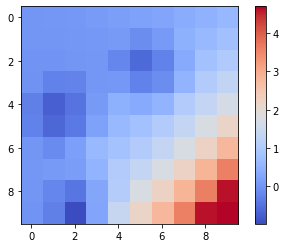

In [23]:
plt.imshow(V1.reshape(10,10).transpose(), cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.show()

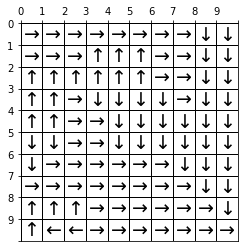

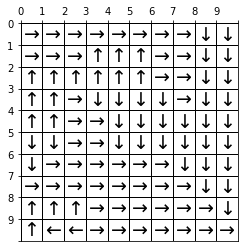

In [24]:
draw_policy_grid(policy1)

In [25]:
def construct_lp_matrices(P,policy,lmda,Rmax):
    S=np.shape(P)[0]
    c=np.concatenate([np.ones((S,)), -lmda*np.ones((S,)), np.zeros((S,))])
    A=np.array([])
    nA=4
    
    Pa1=np.zeros((S,S))
    Pas=np.zeros((3,S,S))
    
    for s in range(S):
        opt_a=policy[s]
        Pa1[s,:]=P[s][opt_a]
        other_actions=np.setdiff1d(range(nA), opt_a)
        for i,a in enumerate(other_actions):
            Pas[i,s,:]=P[s][a]
            
    I, Z=np.eye(S), np.zeros((S,S))
    for i in range(nA-1):
        Pa=Pas[i]
        temp=np.hstack((I, Z, np.matmul(Pa - Pa1, np.linalg.inv(I - gamma*np.array(Pa1)))))
        temp=np.vstack((temp, np.hstack((Z, Z, np.matmul(Pa - Pa1, np.linalg.inv(I - gamma*np.array(Pa1)))))))
        if (A.shape[0]==0): A=temp
        else: A=np.vstack((temp, A))
            
    A=np.vstack((A, np.hstack((Z, -I, I))))
    A=np.vstack((A, np.hstack((Z, -I, -I))))
    A=np.vstack((A, np.hstack((Z, Z, I))))
    A=np.vstack((A, np.hstack((Z, Z, -I))))
    b=np.concatenate([np.zeros((2*(nA-1)*S+2*S,)), Rmax*np.ones((2*S,))])
    return [c,A,b]

In [26]:
def solve_irl(P,policy,Rmax,lmda=None):
    if lmda is None: raise NameError("Please specify lambda")
    solvers.options['show_progress']=False
    c,A,b=construct_lp_matrices(P,policy,lmda,Rmax)
    solution=solvers.lp(-matrix(c.transpose()),matrix(A),matrix(b))
    return np.array(solution['x'][-100:]).squeeze()

In [27]:
def calc_accuracy_over_lmdas(P,target_policy,Rmax,lmdas):
    accuracy=np.zeros_like(lmdas)
    for i,lmda in enumerate(tqdm(lmdas)):
        R_predicted=solve_irl(P,target_policy,Rmax,lmda)
        V,predicted_policy=fast_value_iteration(P,R_predicted)
        accuracy[i]=(predicted_policy==target_policy).sum()/100
    return accuracy

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:31<00:00, 15.83it/s]


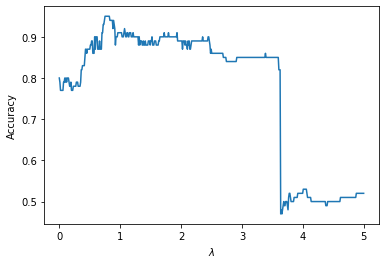

In [28]:
#Q11
R1max=np.amax(np.abs(R1))
lmdas=np.linspace(0,5,500)
accuracy_1=calc_accuracy_over_lmdas(P1,policy1,R1max,lmdas)
plt.plot(lmdas,accuracy_1)
plt.ylabel('Accuracy')
plt.xlabel('$\lambda$')
plt.savefig('ECE232E_plots/Project3_plots/q11.png', bbox_inches='tight')

In [29]:
#Q12
lmda_max_1=lmdas[np.argmax(accuracy_1)]
print(lmda_max_1)

0.751503006012024


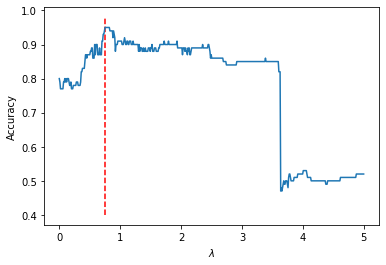

In [30]:
plt.plot(lmdas,accuracy_1)
plt.ylabel('Accuracy')
plt.xlabel('$\lambda$')
plt.vlines(0.7515,0.4,0.98,colors='red',linestyles='dashed')
plt.savefig('ECE232E_plots/Project3_plots/q12.png', bbox_inches='tight')

In [31]:
max(accuracy_1)

0.95

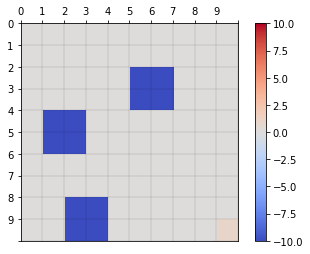

In [32]:
#Q13
fig=draw_heatmap_mod(R1)
fig.savefig('ECE232E_plots/Project3_plots/q13_a.png', bbox_inches='tight')

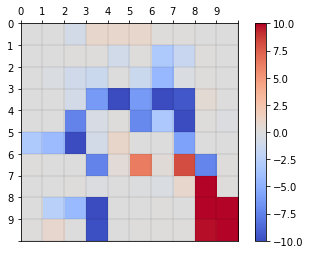

In [33]:
R_predicted_1=solve_irl(P1,policy1,R1max,lmda_max_1)
fig1=draw_heatmap_mod(R_predicted_1)
fig1.savefig('ECE232E_plots/Project3_plots/q13_b.png', bbox_inches='tight')

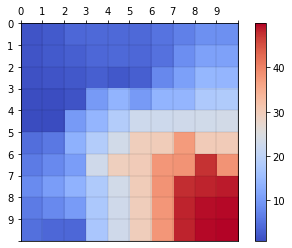

In [34]:
#Q14
V_predicted_1,predicted_policy_1=fast_value_iteration(P1,R_predicted_1)
fig=draw_heatmap(V_predicted_1)
fig.savefig('ECE232E_plots/Project3_plots/q14.png', bbox_inches='tight')

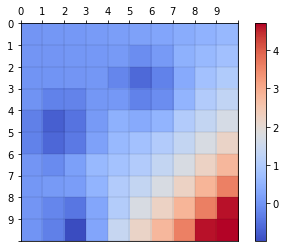

In [35]:
#Q15
fig=draw_heatmap(V1)
fig.savefig('ECE232E_plots/Project3_plots/q15.png', bbox_inches='tight')

In [36]:
(policy1==predicted_policy_1).sum()

95

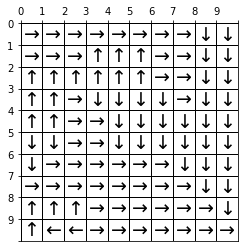

In [37]:
#Q16
fig=draw_policy_grid(policy1)
fig.savefig('ECE232E_plots/Project3_plots/q16.png', bbox_inches='tight')

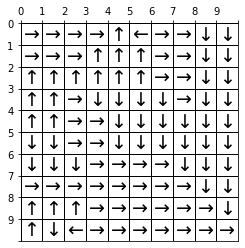

In [38]:
#Q17
fig=draw_policy_grid(predicted_policy_1)
fig.savefig('ECE232E_plots/Project3_plots/q17.png', bbox_inches='tight')

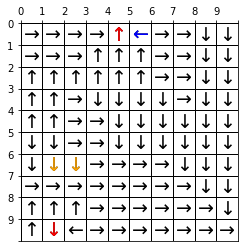

In [39]:
policy_arrows=np.chararray((100,), unicode=True)
for s in range(100):
    a=predicted_policy_1[s]
    if(a==0):
        policy_arrows[s]='↑'
    elif(a==1):
        policy_arrows[s]='→'
    elif(a==2):
        policy_arrows[s]='↓'
    elif(a==3):
        policy_arrows[s]='←'
pa=policy_arrows.reshape(10,10)
board = np.ones((10,10,3))
fig, ax = plt.subplots()
ax.imshow(board, interpolation='nearest', aspect='auto')
ax.grid(color='k', linewidth=1)

for i in range(10):
    for j in range(10):
        ax.text(i, j, pa[i][j], size=19, ha='center', va='center')
ax.text(1, 6, pa[1][6], size=19, ha='center', va='center',color='orange')
ax.text(1, 9, pa[1][9], size=19, ha='center', va='center',color='red')
ax.text(2, 6, pa[2][6], size=19, ha='center', va='center',color='orange')
ax.text(4, 0, pa[4][0], size=19, ha='center', va='center',color='red')
ax.text(5, 0, pa[5][0], size=19, ha='center', va='center',color='blue')

ax.set(xticks=np.arange(-0.5, 10, 1), yticks=np.arange(-0.5, 10, 1))
ax.set_xticklabels(np.arange(0, 10, 1))
ax.set_yticklabels(np.arange(0, 10, 1))
ax.xaxis.tick_top()
ax.axis('image')
fig.savefig('ECE232E_plots/Project3_plots/q17_color.png', bbox_inches='tight')

In [40]:
print(pd.DataFrame(V_predicted_1.reshape(10,10).transpose()))

          0          1          2          3          4          5          6  \
0  1.933399   2.476453   4.109942   4.218647   4.244043   4.262587   5.327321   
1  1.925036   2.457573   3.162650   4.091058   4.179402   4.089253   5.320193   
2  1.507871   1.895224   2.417939   3.146569   2.429456   3.169035   7.921626   
3  1.180871   1.179962   1.830578  10.185949  13.979791  10.197487  13.978895   
4  0.927892   0.926242  10.162452  14.256523  18.706885  22.595369  22.646752   
5  4.764215   6.074277  13.393071  18.695145  23.332122  29.469035  29.918636   
6  6.375152   8.145592  10.562084  22.934870  29.339152  30.134409  37.996377   
7  8.209128  10.536985  13.670020  17.974992  23.424496  29.930550  38.315911   
8  6.398790   8.121710  10.393178  17.598597  23.044270  29.758089  37.993166   
9  5.033457   4.061999   4.061998  17.324386  23.036519  29.758089  37.993166   

           7          8          9  
0   6.880641   8.792935   8.792933  
1   8.682709  11.231774  11.180088